In [2]:
import time
import numpy as np
from IPython.display import display
import ipywidgets as widgets
from matplotlib import pyplot as plt
from qualang_tools.units import unit
u = unit(coerce_to_integer=True)
from qm.qua import *
from qualang_tools.loops import from_array
import QM

2026-02-01 14:21:53,624 - qm - INFO     - Starting session: c423a3c4-cfd4-4eb7-8059-3a87375b75bd


In [3]:
from scipy.optimize import curve_fit

In [36]:
t_min = 100 // 4
t_max = 50000 // 4
dt = 4000 // 4
durations = np.arange(t_min, t_max, dt)
phase_2_pi = np.linspace(0, 1, 20)
n_avg = 10000
print(f"Estimated time {sum(durations*4e-9 + 2e-6)*len(phase_2_pi)*n_avg:.1f}s")

Estimated time 67.9s


In [37]:
# Pulse duration sweep (in clock cycles = 4ns) - must be larger than 4 clock cycles
###################
# The QUA program #
###################
with program() as qmprog:
    n = declare(int)  # QUA variable for the averaging loop
    t = declare(int)  # QUA variable for the qubit pulse duration
    I = declare(fixed)  # QUA variable for the measured 'I' quadrature
    Q = declare(fixed)  # QUA variable for the measured 'Q' quadrature
    fs = declare(int)
    phi = declare(fixed)
    Sz = declare(fixed)
    Sz_st = declare_stream()  # Stream for the state

    update_frequency('resonator',59980000)
    with for_(n, 0, n < n_avg, n + 1):  # QUA for_ loop for averaging
        with for_(*from_array(t, durations)):  # QUA for_ loop for sweeping the pulse duration
            with for_(*from_array(phi, phase_2_pi)): 
                # Play the qubit pulse with a variable duration (in clock cycles = 4ns)
                play("x90"*amp(0.88), "qubit")
                wait(t)
                frame_rotation_2pi(phi, "qubit")
                play("x90"*amp(0.88), "qubit")            
                align("qubit", "resonator")
                # Measure the state of the resonator
                measure(
                    "readout",
                    "resonator",
                    dual_demod.full("cos", "sin", I),
                    dual_demod.full("minus_sin", "cos", Q),
                    )
                    # Send back qubit to ground state
                assign(Sz, Util.cond(Q>2e-4, -0.5, 0.5))
                
                with if_(Q>2e-4):
                    play("pi", "qubit", duration=108*u.ns)
    
                save(Sz, Sz_st)

    with stream_processing():
        # Cast the data into a 1D vector, average the 1D vectors together and store the results on the OPX processor
        Sz_st.buffer(len(phase_2_pi)).buffer(len(durations)).buffer(n_avg).map(FUNCTIONS.average(0)).save("Sz")


# Send the QUA program to the OPX, which compiles and executes it
job = QM.Job(qmprog)

Button(description='Abort', style=ButtonStyle())

Output(outputs=({'output_type': 'stream', 'name': 'stdout', 'text': 'Sending job to qm-1698964092813...'}, {'o…

HTML(value='')

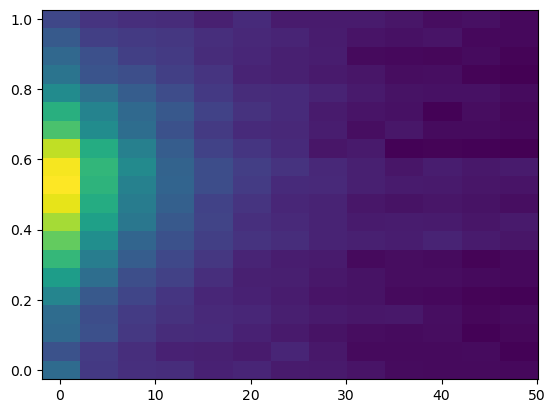

In [38]:
Sz, = job.get_results("Sz")
fig,ax=plt.subplots()
t = 4e-3*durations 
ax.pcolormesh(t,phase_2_pi,Sz.T)

[0.17162276 9.29537913]


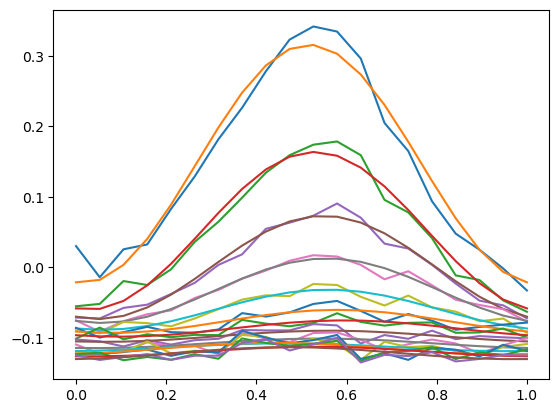

In [42]:
fig,ax=plt.subplots()
fun = lambda phi,a,ofs,phi0 : -a*np.cos(2*np.pi*phi+phi0)+ofs
a = np.zeros(Sz.shape[0])
popt = (0.4,0,0.1)
for i in range(Sz.shape[0]):
    popt,pcov = curve_fit(fun,phase_2_pi,Sz[i],popt)
    a[i] = popt[0]
    ax.plot(phase_2_pi,Sz[i],phase_2_pi,fun(phase_2_pi,*popt))
fun = lambda t,a,τ : a*np.exp(-t/τ)
t = durations*4e-3
popt,pcov = curve_fit(fun,t,a,(a[0],10))
print(popt)

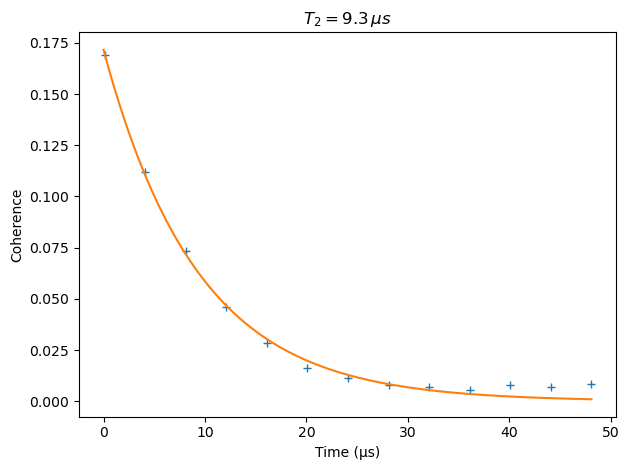

In [43]:
fig,ax=plt.subplots()
tfine = np.linspace(0,t.max(),1000)
ax.plot(t,a,'+',tfine,fun(tfine,*popt))
plt.xlabel('Time (µs)')
plt.ylabel('Coherence')
ax.set_title(rf'$T_2={popt[1]:.1f} \, \mu s$')
fig.tight_layout()
#fig.savefig('RabiChevrons.png')